# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
# Define transforms
#the images are only 32 x 32

transform_train = transforms.Compose([
    transforms.Resize(32), 
    transforms.RandomCrop(32),  #Data Augmentation - randomly cropping image 32 x 32
    transforms.RandomHorizontalFlip(),  #Data Augemtation - randomly flipping the image
    transforms.RandomRotation(30),  #Data Augmentation - randomly rotating the image 30 degrees
    transforms.ToTensor(),  #converting the images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], 
                        [0.5, 0.5, 0.5])  #normalizing the image colour stations
])

#no data augmentation in the test data
transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),  #converting the images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], 
                        [0.5, 0.5, 0.5])  #normalizing the image colour stations
])

# Create training set and define training dataloader
import torchvision.datasets as datasets

trainset = datasets.CIFAR10(root='./data', train = True, download = True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) 


# Create test set and define test dataloader
testset = datasets.CIFAR10(root='./data', train = False, download = True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [12]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

In [16]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [18]:
for image, label in trainloader:
    print(image)
    print(label)
    break

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -

In [19]:
image.shape

torch.Size([64, 3, 32, 32])

The **image** has a 3 color channels and 32 x 32 dimensions. Each *image* is a batch of 64 pictures, each with 3 color channels and dimension of 32 x 32

In [21]:
label.shape

torch.Size([64])

The **label** is a 1D matrix of 64 values, each corresponding to an input image/picture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


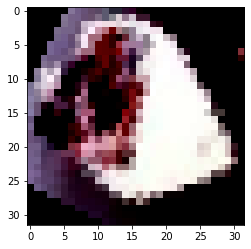

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


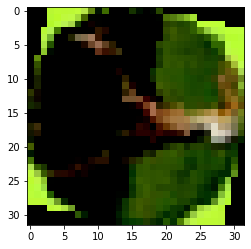

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


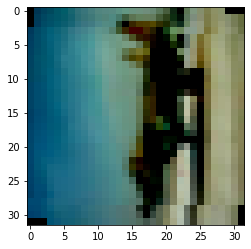

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


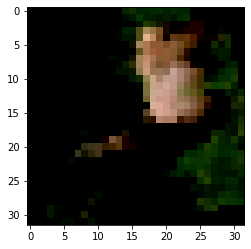

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


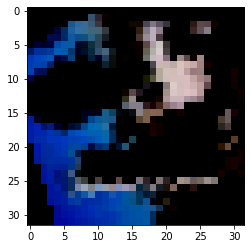

In [93]:
# Explore data
## YOUR CODE HERE ##

show5(trainloader);

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

The photos will be flattened, which means that the size of the input will be *3 x 32x32=3072*

In [84]:
#building the NN architecture

class Image_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        #defining the layers of the fully connected Neural Network
        
        self.input = nn.Linear(3072, 1024)
        self.hidden1 = nn.Linear(1024, 512)  #we are only going to start with one hidden layer 
        self.hidden2 = nn.Linear(512, 256)
        self.output = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(p = 0.2)  #defining dropout with probability of 20% to avoid overfitting
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)  #flattening the input
        
        #defining a forward pass
        
        x = self.dropout(F.relu(self.input(x)))
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        
        x = F.log_softmax(self.output(x), dim = 1)  #no dropout on the output layer

        return x

For a starting neural network, we are only going to have a single *hidden layer* in the fully connected network. The reason for this is *One hidden layer is sufficient for the large majority of problems*

**Ref:** https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [31]:
image.view(image.shape[0], -1).shape

torch.Size([64, 3072])

In [89]:
## YOUR CODE HERE ##

model = Image_Classifier()   #instantiating the model

criterion = nn.NLLLoss()   #NLL Loss function is used as the output is a log_softmax
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.5)  #using the Adam optimizer 

In [90]:
model.parameters

<bound method Module.parameters of Image_Classifier(
  (input): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>

In [91]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)

The **Adam** optimizer is used because *Adam* is the best among the **adaptive optimizers** in most of the cases.
As the data is only 6000 datapoints, it is not *huge* by any means. The adaptive learning rate is perfect for sparse data. Having an *Adam* optimizer also allows spares us the need to focus on the learning rate value


**Ref:** https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [92]:
model = Image_Classifier()

epochs = 2
stepsize = 0
printevery = 75
for e in range(epochs):
    
    
    for images, labels in trainloader:
        
        images.requires_grad_(True)
        
        stepsize += 1
        optimizer.zero_grad()                 #setting gradients back to zero
        
        output = model.forward(images)        #doing a forward pass through the model and getting the output
        
        loss = criterion(output, labels)      #calculating the loss from the predicted output

        loss.backward()                       #backpropagating the loss into the network
        optimizer.step()                      #adjusting the weights in the system according to Adam gradient descent


        
        #finding the accuracy of the model
        
        prob = torch.exp(output)              #taking the exp of the output as the output is log fuction
        top_prob, top_class = prob.topk(1)    #getting the class with the highest probability
        labels = labels.view(top_class.shape[0], top_class.shape[1])  #adjusting the shape of labels
        equals = top_class == labels                                  #comparing the prediction with actual value
        equals = equals.type(torch.FloatTensor)        #converting the type to Float Tensor for clalculating mean
        
        accuracy = torch.mean(equals)
        
        if stepsize % printevery ==0:
            print(accuracy)
        
        

tensor(0.0781)
tensor(0.0469)
tensor(0.0312)
tensor(0.0469)
tensor(0.0781)
tensor(0.1406)
tensor(0.0781)
tensor(0.0625)
tensor(0.1094)
tensor(0.1094)
tensor(0.0625)
tensor(0.1094)
tensor(0.0781)
tensor(0.0781)
tensor(0.0625)
tensor(0.0469)
tensor(0.0938)
tensor(0.0156)
tensor(0.0469)
tensor(0.0469)


In [ ]:
## YOUR CODE HERE ##

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
## YOUR CODE HERE ##

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

